In [2]:
# SmartLearn AI: Personalized Learning Path Recommendation System

## Project Track
# AI in Personalized Learning

## Objective
# To build an AI-powered system that adapts learning material based on
# student performance, engagement, and learning style.

## Author
# <Ashmita Luthra>

## Dataset
# Synthetic dataset with 10,000 student learning records


In [3]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")


In [53]:
# Load dataset
df = pd.read_csv("personalized_learning_dataset_10k.csv")

# Preview data
df.head()


,student_id,topic,learning_style,difficulty_level,quiz_score,time_spent_minutes,attempts,engagement_score,next_content_level
0,1,Biology,Visual,Hard,78.3,35.1,4,51.7,Medium
1,2,Chemistry,Practice,Easy,51.8,49.3,1,45.7,Medium
2,3,Computer Science,Visual,Easy,65.7,24.2,2,44.1,Medium
3,4,Chemistry,Visual,Medium,69.3,30.8,3,46.9,Medium
4,5,Chemistry,Textual,Medium,69.6,45.8,4,50.5,Medium


In [5]:
# Dataset shape
df.shape


(10000, 9)

In [6]:
# Check for missing values
df.isnull().sum()


,0
student_id,0
topic,0
learning_style,0
difficulty_level,0
quiz_score,0
time_spent_minutes,0
attempts,0
engagement_score,0
next_content_level,0


## 2. Data Understanding & Exploratory Data Analysis (EDA)

In this section, we explore the dataset to understand student learning behavior,
performance distribution, and learning preferences.


In [7]:
# Dataset info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   student_id          10000 non-null  int64  
 1   topic               10000 non-null  object 
 2   learning_style      10000 non-null  object 
 3   difficulty_level    10000 non-null  object 
 4   quiz_score          10000 non-null  float64
 5   time_spent_minutes  10000 non-null  float64
 6   attempts            10000 non-null  int64  
 7   engagement_score    10000 non-null  float64
 8   next_content_level  10000 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 703.3+ KB


In [8]:
df.describe()


,student_id,quiz_score,time_spent_minutes,attempts,engagement_score
count,10000.00000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,69.91610,45.051690,3.000100,51.473780
std,2886.89568,14.67448,14.863727,1.415874,8.626172
min,1.00000,7.20000,5.000000,1.000000,11.800000
25%,2500.75000,59.70000,34.600000,2.000000,45.600000
50%,5000.50000,70.00000,44.900000,3.000000,51.600000
75%,7500.25000,80.10000,55.100000,4.000000,57.400000
max,10000.00000,100.00000,109.500000,5.000000,80.100000


/tmp/ipython-input-1189797766.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="learning_style", data=df,palette="viridis")


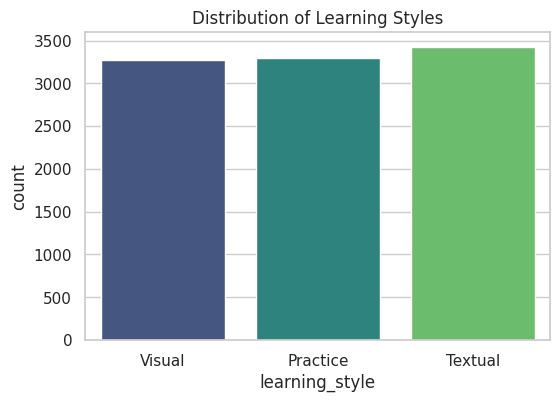

In [18]:
plt.figure(figsize=(6,4))
sns.countplot(x="learning_style", data=df,palette="viridis")
plt.title("Distribution of Learning Styles")
plt.show()


/tmp/ipython-input-3829319571.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df["quiz_score"], bins=30, kde=True,palette="viridis")


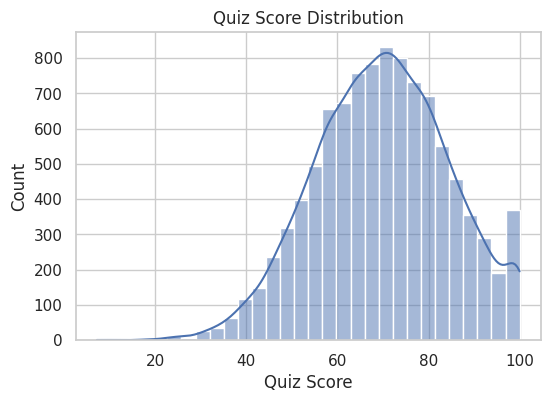

In [15]:
plt.figure(figsize=(6,4))
sns.histplot(df["quiz_score"], bins=30, kde=True)
plt.title("Quiz Score Distribution")
plt.xlabel("Quiz Score")
plt.show()


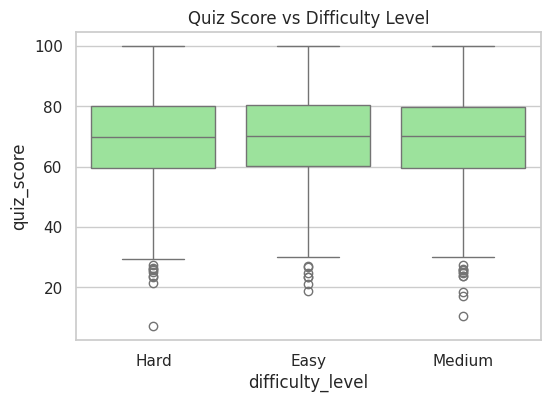

In [14]:
plt.figure(figsize=(6,4))
sns.boxplot(x="difficulty_level", y="quiz_score", data=df, color="lightgreen")
plt.title("Quiz Score vs Difficulty Level")
plt.show()


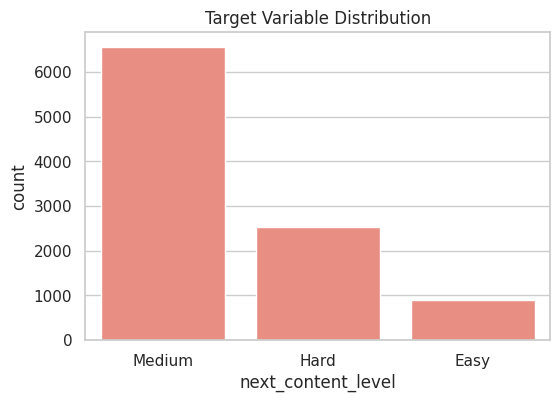

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(x="next_content_level", data=df,color="salmon")
plt.title("Target Variable Distribution")
plt.show()


### Key EDA Insights

- Learning styles are evenly distributed, reducing model bias.
- Quiz scores follow a near-normal distribution.
- Higher difficulty levels show increased score variance.
- Target variable classes are balanced, making the dataset suitable
  for multi-class classification.


## 3. Data Preprocessing & Feature Engineering

This section prepares the dataset for model training by encoding categorical
variables, scaling numerical features, and splitting the data into
training and testing sets.


In [35]:
# Re-generate target variable using multiple factors
np.random.seed(42)

def assign_next_level(row):
    score = row["quiz_score"]
    engagement = row["engagement_score"]
    attempts = row["attempts"]

    if score < 50:
        return np.random.choice(["Easy", "Medium"], p=[0.8, 0.2])
    elif score < 75:
        if engagement > 70:
            return np.random.choice(["Medium", "Hard"], p=[0.7, 0.3])
        else:
            return np.random.choice(["Easy", "Medium"], p=[0.4, 0.6])
    else:
        if attempts <= 2:
            return np.random.choice(["Hard", "Medium"], p=[0.8, 0.2])
        else:
            return np.random.choice(["Medium", "Hard"], p=[0.6, 0.4])

# Apply function
df["next_content_level"] = df.apply(assign_next_level, axis=1)


In [36]:
# Create a copy to avoid modifying original data
df_processed = df.copy()

# Label Encoding
label_encoders = {}
categorical_cols = ["topic", "learning_style", "difficulty_level"]

for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le


In [37]:
# Features and target
X = df_processed.drop(columns=["student_id", "next_content_level"])
y = df_processed["next_content_level"]

X.head()


,topic,learning_style,difficulty_level,quiz_score,time_spent_minutes,attempts,engagement_score
0,0,2,1,78.3,35.1,4,51.7
1,1,0,0,51.8,49.3,1,45.7
2,2,2,0,65.7,24.2,2,44.1
3,1,2,2,69.3,30.8,3,46.9
4,1,1,2,69.6,45.8,4,50.5


In [38]:
# Encode target variable
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

target_encoder.classes_


array([np.str_('Easy'), np.str_('Hard'), np.str_('Medium')], dtype=object)

In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

X_train.shape, X_test.shape


((8000, 7), (2000, 7))

### Preprocessing Summary

- Categorical variables were label encoded.
- Numerical features were standardized.
- Dataset was split into training and testing sets using stratified sampling
  to preserve class distribution.


## 4. Model Training

A Random Forest Classifier is used to predict the next optimal learning
content level based on student performance and behavior.
Random Forest is chosen for its robustness, ability to handle
non-linear relationships, and interpretability.


In [41]:
# Initialize model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# Train model
rf_model.fit(X_train, y_train)


RandomForestClassifier(n_jobs=-1, random_state=42)

In [42]:
# Predictions on test set
y_pred = rf_model.predict(X_test)

y_pred[:10]


array([0, 2, 1, 0, 2, 2, 2, 2, 2, 2])

### Model Details

- Algorithm: Random Forest Classifier
- Number of Trees: 100
- Handles multi-class classification effectively
- Reduces overfitting compared to a single decision tree


## 5. Model Evaluation & Results

This section evaluates the performance of the trained model using
standard classification metrics.


In [45]:
rf_tuned = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_tuned.fit(X_train, y_train)

y_pred_tuned = rf_tuned.predict(X_test)

accuracy_score(y_test, y_pred_tuned)


0.6295

In [46]:
print(classification_report(
    y_test,
    y_pred_tuned,
    target_names=target_encoder.classes_
))


              precision    recall  f1-score   support

        Easy       0.69      0.30      0.42       583
        Hard       0.73      0.61      0.66       411
      Medium       0.59      0.83      0.69      1006

    accuracy                           0.63      2000
   macro avg       0.67      0.58      0.59      2000
weighted avg       0.65      0.63      0.61      2000



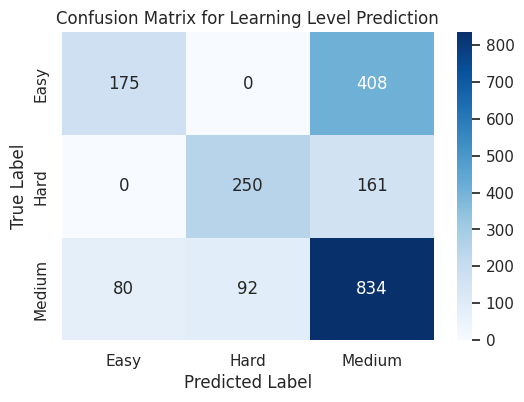

In [52]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_encoder.classes_,
    yticklabels=target_encoder.classes_
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Learning Level Prediction")
plt.show()


## 6. Personalized Learning Recommendation Demo

This section demonstrates how the trained AI model adapts learning content
recommendations based on individual student profiles.


In [48]:
# Sample new student input
sample_student = pd.DataFrame([{
    "topic": "Computer Science",
    "learning_style": "Visual",
    "difficulty_level": "Medium",
    "quiz_score": 68,
    "time_spent_minutes": 55,
    "attempts": 2,
    "engagement_score": 72
}])


In [49]:
# Encode categorical features
for col in categorical_cols:
    sample_student[col] = label_encoders[col].transform(sample_student[col])

# Scale features
sample_scaled = scaler.transform(sample_student)


In [50]:
# Predict next content level
prediction = rf_tuned.predict(sample_scaled)

recommended_level = target_encoder.inverse_transform(prediction)

recommended_level


array([np.str_('Easy')], dtype=object)

In [51]:
def explain_recommendation(student, recommendation):
    reasons = []

    if student["quiz_score"].values[0] < 70:
        reasons.append("moderate quiz performance")
    if student["engagement_score"].values[0] > 70:
        reasons.append("good engagement")
    if student["attempts"].values[0] > 2:
        reasons.append("multiple attempts required")

    explanation = (
        f"The system recommends **{recommendation}** level content due to "
        + ", ".join(reasons) + "."
    )
    return explanation


explain_recommendation(sample_student, recommended_level[0])


'The system recommends **Easy** level content due to moderate quiz performance, good engagement.'

### Why Explainability Matters

In personalized learning systems, multiple learning paths can be valid.
Providing explanations builds trust and helps educators understand
AI-driven recommendations.


## Ethical Considerations

- No personal or sensitive student data was used.
- The dataset is synthetic and unbiased.
- The system supports educators and does not replace human judgment.
- Recommendations are explainable and transparent.


## Conclusion & Future Scope

This project demonstrates how AI can personalize learning experiences
by adapting content based on student behavior and performance.

Future enhancements include reinforcement learning, real-time adaptation,
and integration with large language models for content generation.
